# Import libraries

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB


# Import twitter dataset

In [60]:
# Loading twitter samples (lists) from nltk
nltk.download('twitter_samples')
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
tweets = positive_tweets + negative_tweets
label = np.zeros(len(tweets),dtype='int8')
label[:len(positive_tweets)] = 1

# Converting lists to Pandas Dataframes
tweets_df = pd.DataFrame([label, tweets], index=['label', 'tweet']).T
tweets_df['label'] = tweets_df['label'].astype('int8')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [61]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int8  
 1   tweet   10000 non-null  object
dtypes: int8(1), object(1)
memory usage: 88.0+ KB


# Exploratory data analysis

In [62]:
#Checking for null cells
tweets_df.isnull().sum()

label    0
tweet    0
dtype: int64

In [63]:
#Checking for duplicate tweets
tweets_df['tweet'].duplicated().sum()

0

In [64]:
# Get the length of the tweets
tweets_df['tweet_length'] = tweets_df['tweet'].apply(len)
tweets_df.head()

,label,tweet,tweet_length
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...,111
1,1,@Lamb2ja Hey James! How odd :/ Please call our...,126
2,1,@DespiteOfficial we had a listen last night :)...,107
3,1,@97sides CONGRATS :),20
4,1,yeaaaah yippppy!!! my accnt verified rqst has...,106


       Positive tweets  Negative tweets
count      5000.000000      5000.000000
mean         73.688200        63.387200
std          36.858539        36.704069
min           7.000000         7.000000
25%          42.000000        34.000000
50%          69.000000        54.000000
75%         103.000000        88.000000
max         152.000000       148.000000


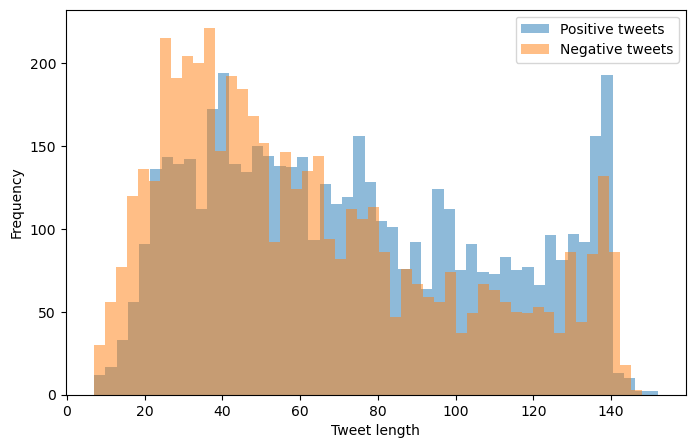

In [65]:
pos_tweet_len = tweets_df[tweets_df['label']==1]['tweet_length']
neg_tweet_len = tweets_df[tweets_df['label']==0]['tweet_length']

tweet_stats = pd.concat([pos_tweet_len.describe(), neg_tweet_len.describe()], axis=1)
tweet_stats.columns = ['Positive tweets', 'Negative tweets']
print(tweet_stats)

plt.figure(figsize=(8, 5))
pos_tweet_len.plot(kind='hist', alpha=0.5, label='Positive tweets', bins=50)
neg_tweet_len.plot(kind='hist', alpha=0.5, label='Negative tweets', bins=50)
plt.xlabel('Tweet length')
plt.ylabel('Frequency')
plt.legend()


# Cleaning of unstructured data

In [66]:
# Define a pipeline to clean up all the tweets 

rx_tick = re.compile(r'\$\w*') # remove stock market tickers like $GE
rx_handle = re.compile(r'\@\w*') # remove handles like @user
rx_RT = re.compile(r'^RT[\s]+')# remove old style retweet text "RT"
rx_hyp = re.compile(r'https?://[^\s\n\r]+') # remove hyperlinks
rx_hash = re.compile(r'#') #removing the hash # sign from the hashtag
rx_alpha = re.compile(r'[^A-Za-z0-9 ]+') #only retain alphabets and numbers

def tweet_filter_1(tweet):
    tweet = tweet.lower()
    tweet = rx_tick.sub('',tweet)
    tweet = rx_handle.sub('',tweet)
    tweet = rx_RT.sub('',tweet)
    tweet = rx_hyp.sub('',tweet)
    tweet = rx_hash.sub('',tweet)
    tweet = rx_alpha.sub('',tweet)
    return tweet


In [67]:
#defining function to remove stopwords and stemming tweets to their base form

nltk_tokenize = TweetTokenizer(reduce_len=True).tokenize
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk_stem = SnowballStemmer(language='english').stem

def tweet_filter_2(tweet):
    tokens = nltk_tokenize(tweet)
    tokens = [nltk_stem(w) for w in tokens if w not in stop_words and len(w)>1]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
#cleaning tweets using a pipeline
tweets_df['cleaned_tweet'] = tweets_df['tweet'].apply(tweet_filter_1)
tweets_df['cleaned_tweet'] = tweets_df['cleaned_tweet'].apply(tweet_filter_2)

#Removing rows with empty "cleaned_tweet" column
tweets_df = tweets_df[tweets_df['cleaned_tweet'].apply(lambda x: x.strip() != '')]
tweets_df.reset_index(drop=True, inplace=True)

tweets_df

,label,tweet,tweet_length,cleaned_tweet
0,1,#FollowFriday @France_Inte @PKuchly57 @Milipol...,111,followfriday top engag member communiti week
1,1,@Lamb2ja Hey James! How odd :/ Please call our...,126,hey jame odd pleas call contact centr 02392441...
2,1,@DespiteOfficial we had a listen last night :)...,107,listen last night bleed amaz track scotland
3,1,@97sides CONGRATS :),20,congrat
4,1,yeaaaah yippppy!!! my accnt verified rqst has...,106,yeaaah yipppi accnt verifi rqst succeed got bl...
...,...,...,...,...
9918,0,I wanna change my avi but uSanele :(,36,wanna chang avi usanel
9919,0,MY PUPPY BROKE HER FOOT :(,26,puppi broke foot
9920,0,where's all the jaebum baby pictures :((,40,where jaebum babi pictur
9921,0,But but Mr Ahmad Maslan cooks too :( https://t...,60,mr ahmad maslan cook


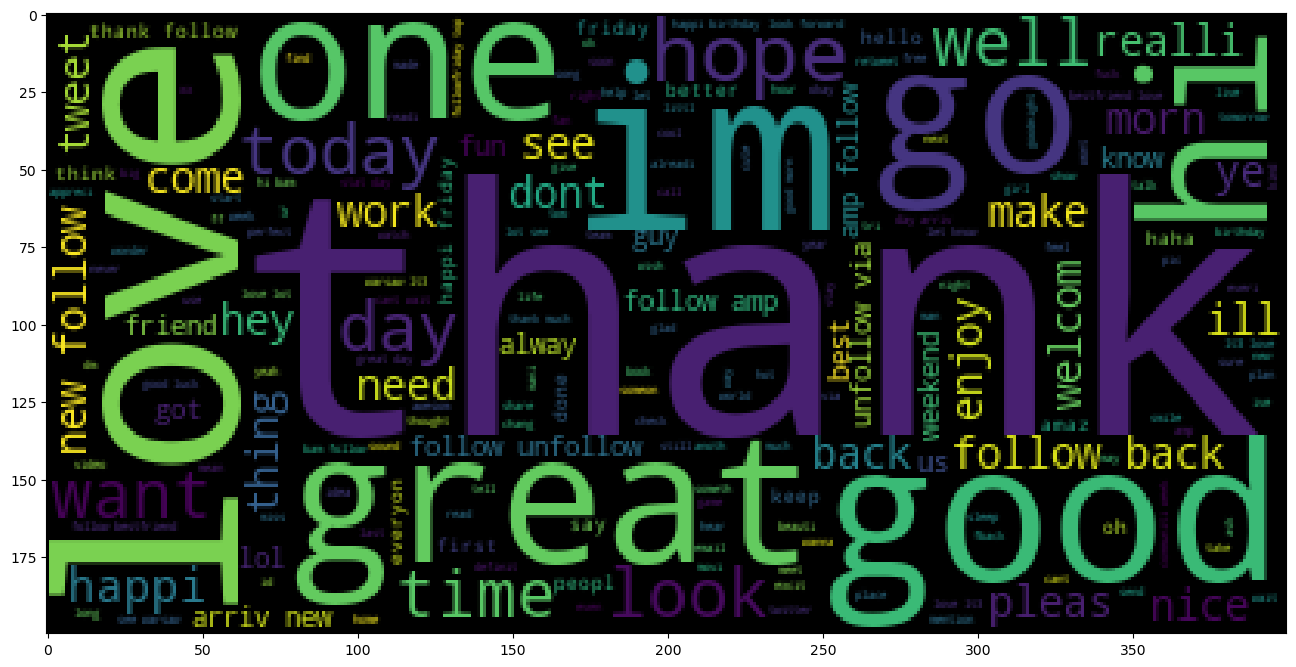

In [69]:
pos_tweet_cleaned = ' '.join(tweets_df[tweets_df['label']==1]['cleaned_tweet'])

plt.figure(figsize=(16,10))
plt.imshow(WordCloud().generate(pos_tweet_cleaned))

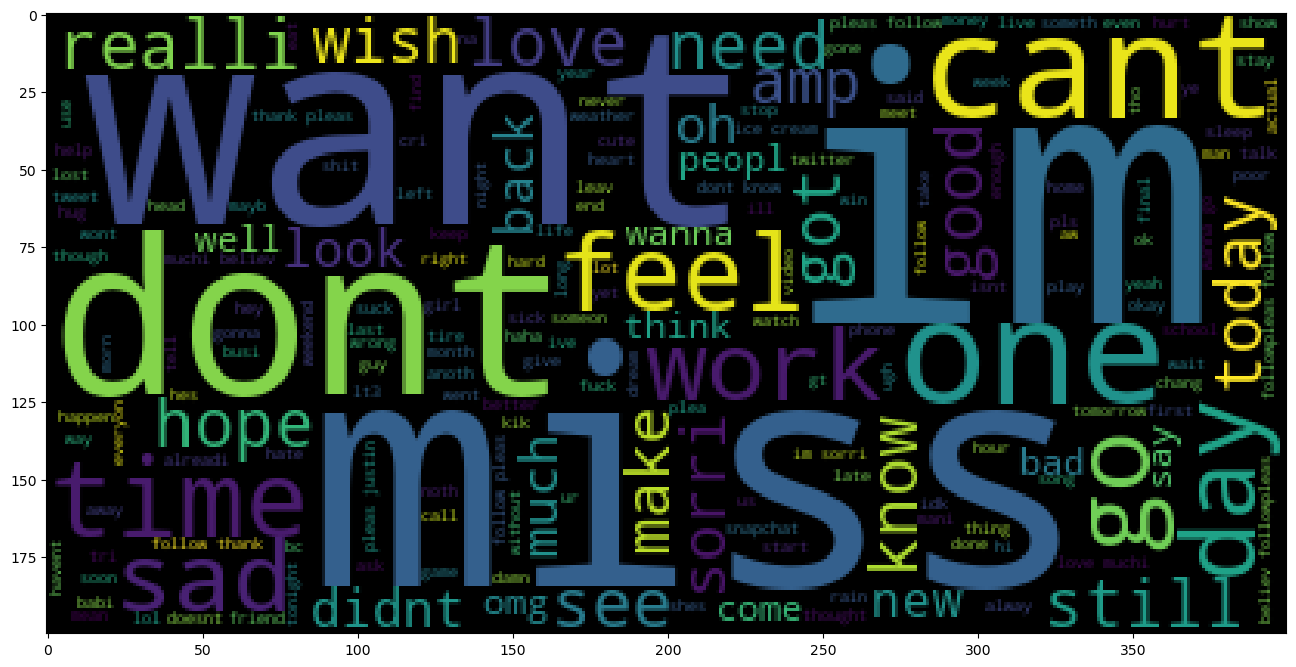

In [70]:
neg_tweet_cleaned = ' '.join(tweets_df[tweets_df['label']==0]['cleaned_tweet'])

plt.figure(figsize=(16,10))
plt.imshow(WordCloud().generate(neg_tweet_cleaned))

# Feature extraction

In [94]:
X_train, X_test, y_train, y_test =  train_test_split(tweets_df['cleaned_tweet'], tweets_df['label'], test_size = 0.15)

In [95]:
#Count Vectorizer: Useful when word frequency is more important than their relative importance across the corpus. It can be a good starting point for simpler models and smaller datasets.
#TF-IDF Vectorizer: Often preferred for more sophisticated text analysis tasks where the importance of words relative to the entire corpus matters. It generally provides better performance for text classification, information retrieval, and similar tasks.


In [96]:
#Feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [97]:
X_train_tfidf.shape

(8434, 5000)

# TRAIN CLASSIFIER MODELS AND EVALUATE KPIs

In [98]:
# Evaluate the model
def eval_model(y_test, y_pred, ModelName):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Model: {ModelName}')
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)

In [101]:
model_NB = MultinomialNB()
model_NB.fit(X_train_tfidf, y_train)
y_pred = model_NB.predict(X_test_tfidf)
eval_model(y_test, y_pred, 'Naive Bayes')

Model: Naive Bayes
Accuracy: 0.758226997985225
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       762
           1       0.74      0.77      0.76       727

    accuracy                           0.76      1489
   macro avg       0.76      0.76      0.76      1489
weighted avg       0.76      0.76      0.76      1489



In [102]:
model_LR = LogisticRegression()
model_LR.fit(X_train_tfidf, y_train)
y_pred = model_LR.predict(X_test_tfidf)
eval_model(y_test, y_pred, 'Logistic Regression')

Model: Logistic Regression
Accuracy: 0.7743451981195433
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       762
           1       0.77      0.76      0.77       727

    accuracy                           0.77      1489
   macro avg       0.77      0.77      0.77      1489
weighted avg       0.77      0.77      0.77      1489



In [103]:
model_GB = GradientBoostingClassifier()
model_GB.fit(X_train_tfidf, y_train)
y_pred = model_GB.predict(X_test_tfidf)
eval_model(y_test, y_pred, 'Gradient Boosting')

Model: Gradient Boosting
Accuracy: 0.7078576225654802
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.91      0.76       762
           1       0.85      0.49      0.62       727

    accuracy                           0.71      1489
   macro avg       0.75      0.70      0.69      1489
weighted avg       0.75      0.71      0.69      1489

